# Training progress plots

In [88]:
import re
import yaml
from argparse import Namespace

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load experiment data
Customize `EXP_DIR` to the output folder of the learned_expert experiment.

Example: `{path/to/output}/ExpertTrainer/learned_expert/{expname}/{timestamp}`

In [ ]:
# EXP_DIR = '/gpfs/work5/0/prjs0799/saved_expert_output/ExpertTrainer/learned_expert/lie_replica/2024-12-02T16:05:21.099935'
EXP_DIR = '/gpfs/work5/0/prjs0799/saved_expert_output/ExpertTrainer/learned_expert/pose_replica/2024-12-02T19:37:01.011236'

In [90]:
CFG_PATH = f'{EXP_DIR}/cfg.yaml'
SCENES_PATH = f'{EXP_DIR}/scenes.txt'
CSV_PATH = f'{EXP_DIR}/trainer_log.csv'

In [91]:
# read config from yaml

class ConfigLoader(yaml.FullLoader):
    """ save cfg as dataclass"""
    def construct_mapping(self, node: yaml.nodes.MappingNode, deep: bool = False) -> dict:
        return Namespace(**{
            self.construct_object(k, deep=deep): self.construct_object(v, deep=deep)
            for k, v in node.value
        })

    def construct_object(self, node, deep=False):
        if isinstance(node, yaml.nodes.MappingNode):
            return self.construct_mapping(node, deep)
        return super().construct_object(node, deep)    
    
with open(CFG_PATH, 'r') as f:
    cfg = yaml.load(f, Loader=ConfigLoader)
cfg

Namespace(expname='DEBUG_expL', output='/gpfs/work5/0/prjs0799/expert_output/ExpertTrainer', setting='learned_expert', setup_seed=43, test=Namespace(batch_size=32, data_gen=Namespace(pose_init=Namespace(pose_hist='gt'), pose_mixing=Namespace(mapped_pose='gt')), scenes=['configs/Replica/office1_debug_trainer.yaml']), train=Namespace(batch_size=16, data_gen=Namespace(pose_init=Namespace(add_noise_scale=0.02, pose_hist='gt'), pose_mixing=Namespace(mapped_pose='gt')), epochs=4, folds=3, inner_reps=2, lr=1e-06, mix_method='learned_lie', outer_reps=1, scenes=['configs/Replica/office0_debug_trainer.yaml'], val_batch_size=32))

In [92]:
# read scenes, in order of processing

with open(SCENES_PATH, 'r') as f:
    scenes_list = f.readlines()
# strip and remove ".yaml$" extension
scenes_list = [re.sub(r'\.yaml$', '', scene.strip()) for scene in scenes_list]
scenes_list

['configs/Replica/office0_debug_trainer']

In [93]:
n_scenes = len(scenes_list)  # total number of scenes
assert n_scenes == len(cfg.train.scenes) * cfg.train.outer_reps
n_reps = cfg.train.inner_reps
n_folds = cfg.train.folds
n_epochs = cfg.train.epochs
# NOTE: different number of batches per scene/fold

print(f'{n_scenes=}\n{n_reps=}\n{n_folds=}\n{n_epochs=}')

n_scenes=1
n_reps=2
n_folds=3
n_epochs=4


In [94]:
# create dataframe

df = pd.read_csv(CSV_PATH)
df

,scene,rep,fold,epoch,batch,loss_batch,loss_batch_ema,loss_epoch,val_loss_epoch,loss_fold,loss
0,0,0,0.0,0.0,0.0,0.186678,0.186678,NaN,NaN,NaN,NaN
1,0,0,0.0,0.0,1.0,0.182716,0.184036,NaN,NaN,NaN,NaN
2,0,0,0.0,0.0,2.0,0.156753,0.170395,NaN,NaN,NaN,NaN
3,0,0,0.0,0.0,3.0,0.161697,0.166916,NaN,NaN,NaN,NaN
4,0,0,0.0,0.0,4.0,0.138630,0.157487,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
147,0,1,2.0,3.0,3.0,0.076151,0.073442,NaN,NaN,NaN,NaN
148,0,1,2.0,3.0,4.0,0.099580,0.082154,NaN,NaN,NaN,NaN
149,0,1,2.0,3.0,NaN,NaN,NaN,0.082154,0.041412,NaN,NaN
150,0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.034424,NaN


In [95]:
# column data

df.columns.tolist()

['scene',
 'rep',
 'fold',
 'epoch',
 'batch',
 'loss_batch',
 'loss_batch_ema',
 'loss_epoch',
 'val_loss_epoch',
 'loss_fold',
 'loss']

### Complete training data
Add time step and batch num info to DataFrame

In [96]:
# compute time step

df_fill = df[['scene', 'rep', 'fold', 'epoch', 'batch']].ffill()
assert df_fill.notnull().all().all()
df_fill = df_fill.astype(int)
df_fill

,scene,rep,fold,epoch,batch
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,2
3,0,0,0,0,3
4,0,0,0,0,4
...,...,...,...,...,...
147,0,1,2,3,3
148,0,1,2,3,4
149,0,1,2,3,4
150,0,1,2,3,4


In [97]:
# compute number of batches per epoch

df_fill['num_batches'] = g = df_fill.groupby(['scene', 'rep', 'fold', 'epoch'])['batch'].transform('nunique')
df_fill

,scene,rep,fold,epoch,batch,num_batches
0,0,0,0,0,0,5
1,0,0,0,0,1,5
2,0,0,0,0,2,5
3,0,0,0,0,3,5
4,0,0,0,0,4,5
...,...,...,...,...,...,...
147,0,1,2,3,3,5
148,0,1,2,3,4,5
149,0,1,2,3,4,5
150,0,1,2,3,4,5


In [98]:
# number of total time steps
# folds run in parallel
n_times = df_fill.drop(columns='fold').drop_duplicates().shape[0]
n_times

40

In [99]:
t = ((df_fill['scene'] * n_reps + df_fill['rep']) * n_epochs + df_fill['epoch']) * df_fill['num_batches'] + df_fill['batch']
df['t'] = t+1  # 1 to n_times
assert df['t'].nunique() == n_times
df

,scene,rep,fold,epoch,batch,loss_batch,loss_batch_ema,loss_epoch,val_loss_epoch,loss_fold,loss,t
0,0,0,0.0,0.0,0.0,0.186678,0.186678,NaN,NaN,NaN,NaN,1
1,0,0,0.0,0.0,1.0,0.182716,0.184036,NaN,NaN,NaN,NaN,2
2,0,0,0.0,0.0,2.0,0.156753,0.170395,NaN,NaN,NaN,NaN,3
3,0,0,0.0,0.0,3.0,0.161697,0.166916,NaN,NaN,NaN,NaN,4
4,0,0,0.0,0.0,4.0,0.138630,0.157487,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,1,2.0,3.0,3.0,0.076151,0.073442,NaN,NaN,NaN,NaN,39
148,0,1,2.0,3.0,4.0,0.099580,0.082154,NaN,NaN,NaN,NaN,40
149,0,1,2.0,3.0,NaN,NaN,NaN,0.082154,0.041412,NaN,NaN,40
150,0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.034424,NaN,40


### Separate log info for each level
Each data column is logged at different level (scene/rep/epoch/batch).

In [100]:
# info exclusive to each level

batch_level = df['batch'].notnull()
df_batches = df[batch_level].reset_index(drop=True)  # logged info at batch level

epoch_level = df['epoch'].notnull() & ~df['batch'].notnull()
df_epochs = df[epoch_level].reset_index(drop=True)  # logged info at epoch level

fold_level = df['fold'].notnull() & ~df['epoch'].notnull()
df_folds = df[fold_level].reset_index(drop=True)  # logged info at fold level

rep_level = df['rep'].notnull() & ~df['fold'].notnull()
df_reps = df[rep_level].reset_index(drop=True)  # logged info at rep level

scene_level = df['scene'].notnull() & ~df['rep'].notnull()
df_scenes = df[scene_level].reset_index(drop=True)  # logged info at scene level

len(df_batches), len(df_epochs), len(df_folds), len(df_reps), len(df_scenes)

(120, 24, 6, 2, 0)

In [101]:
# show info logged at each level

print("df_batches:", df_batches.dropna(axis=1).filter(like='loss').columns.tolist())
print("df_epochs:", df_epochs.dropna(axis=1).filter(like='loss').columns.tolist())
print("df_folds:", df_folds.dropna(axis=1).filter(like='loss').columns.tolist())
print("df_reps:", df_reps.dropna(axis=1).filter(like='loss').columns.tolist())

df_batches: ['loss_batch', 'loss_batch_ema']
df_epochs: ['loss_epoch', 'val_loss_epoch']
df_folds: ['loss_fold']
df_reps: ['loss']


In [102]:
# times where each level ends

t_batches = df['t'].unique()  # batch-level info logged at batch end, every time step
t_epochs = df_epochs['t'].unique()  # epoch-level info logged at epoch end
t_reps = df_reps['t'].unique()  # rep-level info logged at rep end
t_scenes = t_reps[1::n_reps]  # no info logged at scene-level
t_scenes = t_reps[n_reps-1::n_reps]  # no info logged at scene-level

# assert len(t_batches) == n_times  # all time steps are logged
# assert len(t_epochs) == n_scenes * n_reps * n_epochs  # logged at epoch end
# assert len(t_reps) == n_scenes * n_reps == len(df_folds['t'].unique())  # folds in in parallel with reps, logged at rep end
# assert len(df_scenes['t'].unique()) == 0  # no info at scene level

# print('t_batches:', len(t_batches), t_batches)
# print('t_epochs:', len(t_epochs), t_epochs)
# print('t_reps:', len(t_reps), t_reps)
# print('t_scenes:', len(t_scenes), t_scenes)

## Plot batch loss per fold

All folds are computed in parallel and combined at the end of each repetition.
These plots show the loss logged by the fold with a specific index $k$ at each time, but in the same plot the fold train/val data is not the same across different repetitions.

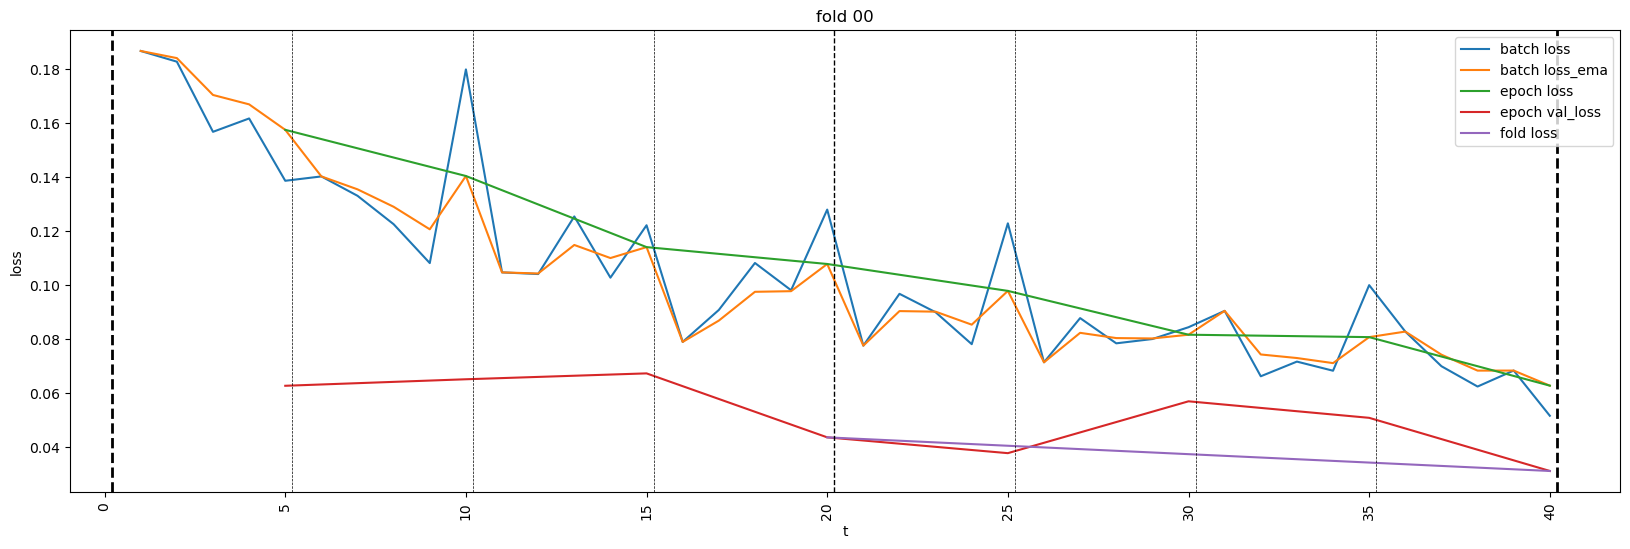

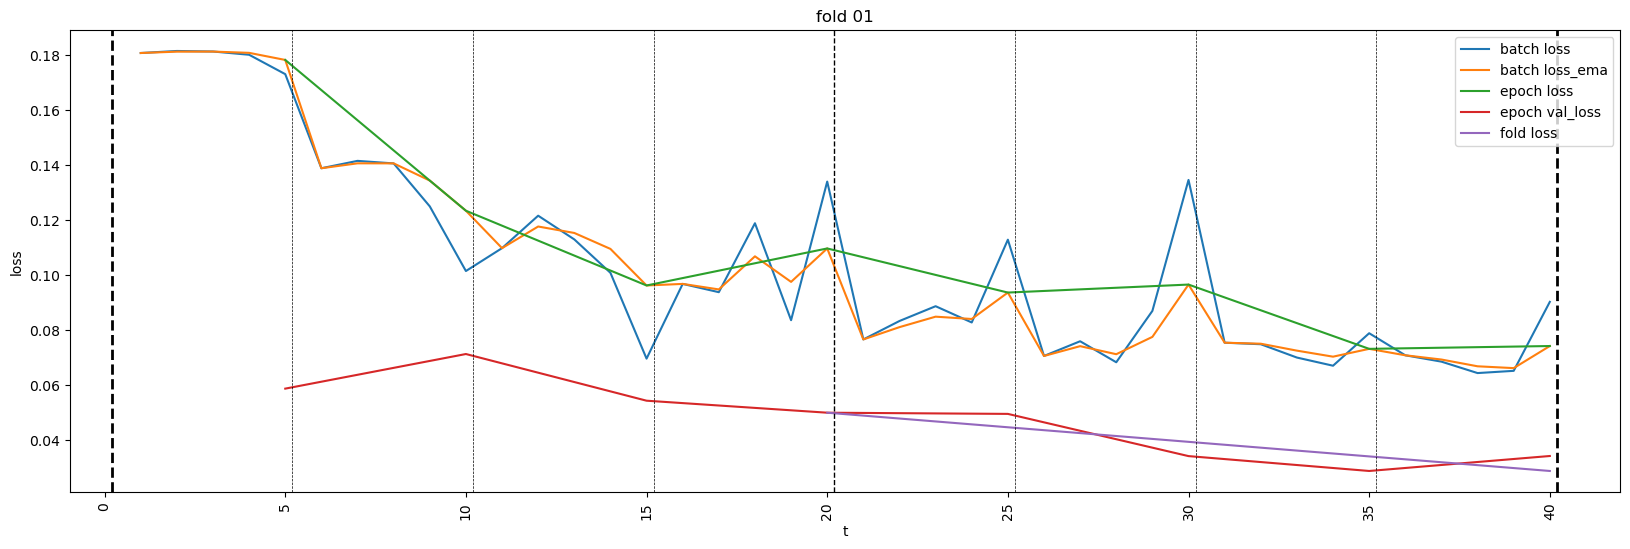

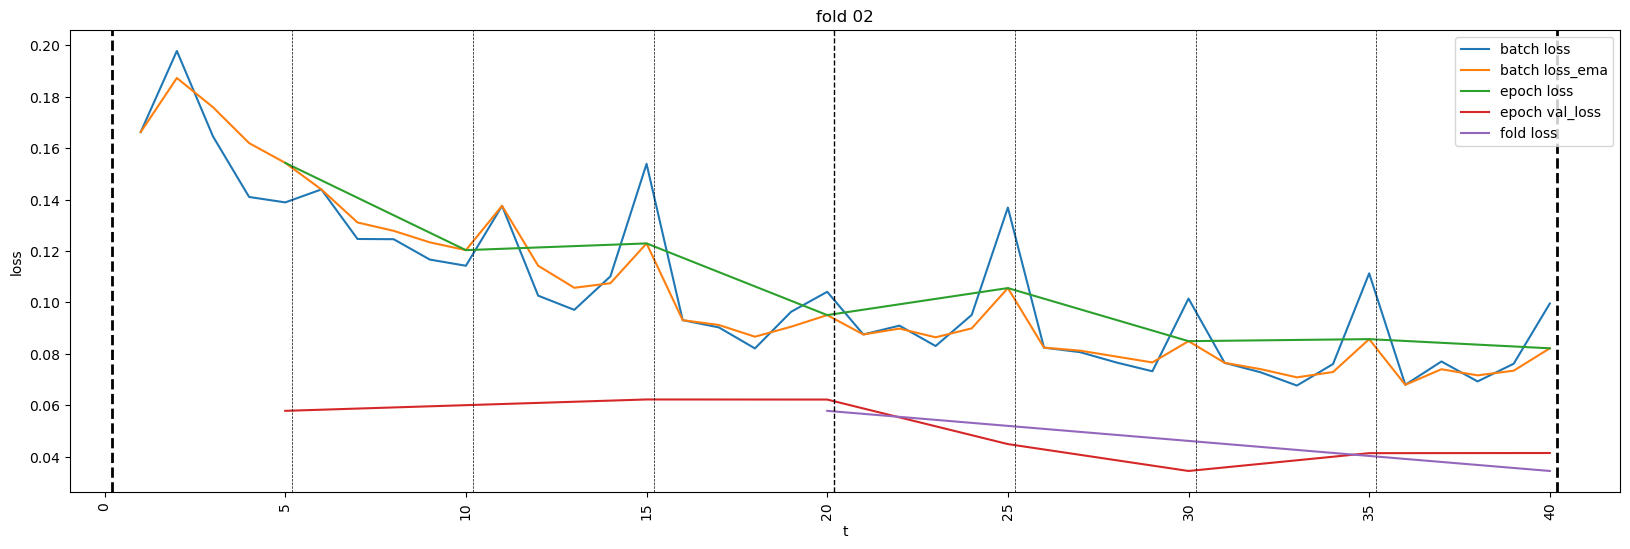

In [103]:
for k in range(n_folds):
    plt.figure(figsize=(20, 6))
    plt.title(f'fold {k:02d}')
    sns.lineplot(df[df['fold']==k], x='t', y='loss_batch', label='batch loss')
    sns.lineplot(df[df['fold']==k], x='t', y='loss_batch_ema', label='batch loss_ema')
    sns.lineplot(df[df['fold']==k], x='t', y='loss_epoch', label='epoch loss')
    sns.lineplot(df[df['fold']==k], x='t', y='val_loss_epoch', label='epoch val_loss')
    sns.lineplot(df[df['fold']==k], x='t', y='loss_fold', label='fold loss')

    plt.axvline(0.2, color='black', linestyle='--', linewidth=2)
    for t in t_scenes:
        plt.axvline(t + 0.2, color='black', linestyle='--', linewidth=2)
    for t in t_reps:
        if t not in t_scenes:
            plt.axvline(t + 0.2, color='black', linestyle='--', linewidth=1)
    for t in t_epochs:
        if t not in t_reps:
            plt.axvline(t + 0.2, color='black', linestyle='--', linewidth=0.5)

    plt.legend(loc='upper right')
    plt.xticks([0]+t_epochs.tolist(), rotation=90)
    plt.ylabel('loss')
    # plt.xlim(1000, 2000)  # example
    plt.show()

## Plot fold losses

Plot the train and validation loss of each fold and best fold.

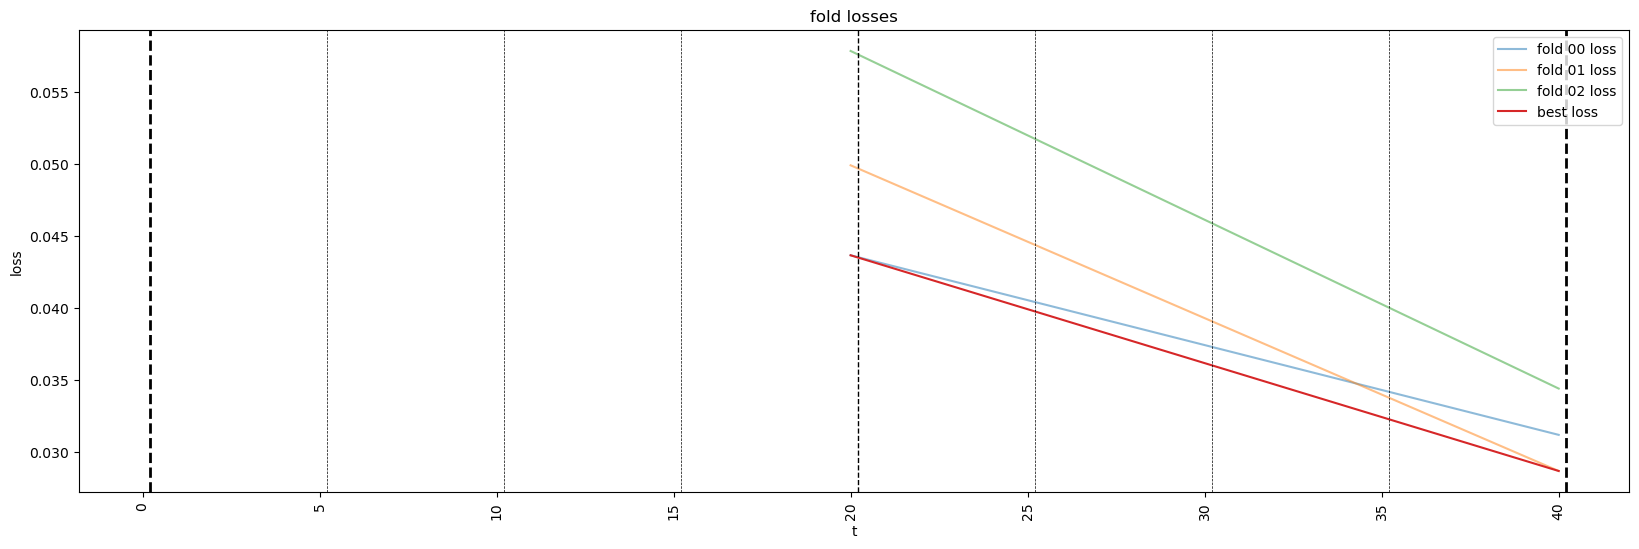

In [104]:
plt.figure(figsize=(20, 6))
plt.title(f'fold losses')
for k in range(n_folds):
    sns.lineplot(df[df['fold']==k], x='t', y='loss_fold', label=f'fold {k:02d} loss', alpha=0.5)
sns.lineplot(df, x='t', y='loss', label='best loss')

plt.axvline(0.2, color='black', linestyle='--', linewidth=2)
for t in t_scenes:
    plt.axvline(t + 0.2, color='black', linestyle='--', linewidth=2)
for t in t_reps:
    if t not in t_scenes:
        plt.axvline(t + 0.2, color='black', linestyle='--', linewidth=1)
for t in t_epochs:
    if t not in t_reps:
        plt.axvline(t + 0.2, color='black', linestyle='--', linewidth=0.5)

plt.legend(loc='upper right')
plt.xticks([0]+t_epochs.tolist(), rotation=90)
plt.ylabel('loss')
plt.show()